In [24]:
import math
import gym 
import random 
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image 
from collections import namedtuple
from itertools import count

In [25]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [26]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=img_height*img_width*3, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=24),
            nn.ReLU(),
            nn.Linear(in_features=24, out_features=2),
        )
    def forward(self, t):
        try:
            t = t.flatten(start_dim=1) 
        except:
            t = t.flatten()
        t = self.model(t)
        return t        

In [27]:
x = torch.rand(size=(3,5,5))
Model = DQN(5,5)
# Model.forward(x)

In [28]:
Experience = namedtuple('Experience',('state', 'action', 'reward', 'next_state') )
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity 
        self.memory = []
        self.push_count = 0
    def Push(self, experience):
        if len(self.memory)<self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    def Sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def CanProvide(self):
        return len(self.memory)>=batch_size

class EpsilonGreedy():
    def __init__(self, start, end, decay):
        self.start = start 
        self.end = end
        self.decay = decay
    def getexprate(self, current_step):
        return self.end + (self.start-self.end)*math.exp(-self.decay*current_step)
    
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    def SelectAction(self, state, policy_net):
        rate = self.strategy.getexprate(self.current_step)
        self.step += 1
        if rate>random.random():
            action = random.randrange(self.num_actions) # Explore 
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).item().to(self.device ) # Exploit
    

In [19]:
# Creating the environment manager
class CartPoleManager():
    def __init__(self, device):
        self.device = device 
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.num_actions_available.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done: 
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) # Pytorch needs CHW
        screen = self.crop_screen(screen)
        screen = self.transform_screen_data(screen)
        return screen
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height*0.4)
        bottom = int(screen_height*0.8)
        screen = screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale and convert to tensor 
        screen = np.ascontiguousarray(screen, dtype = np.float32)/255
        screen = torch.from_numpy(screen)
        # compose image transformations using torchvision 
        resize = T.Compose([T.ToPILImage(),
                           T.Resize((40,90)),
                           T.ToTensor()])
        return resize(screen).unsqueeze(0).to(device)

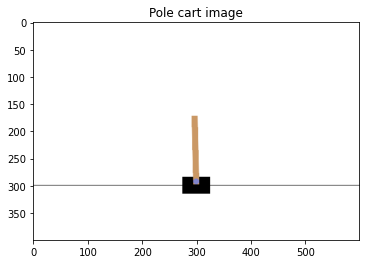

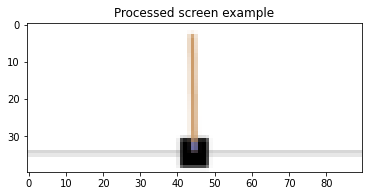

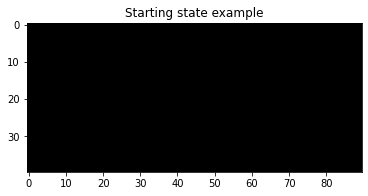

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


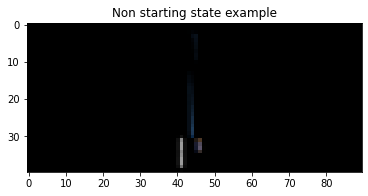

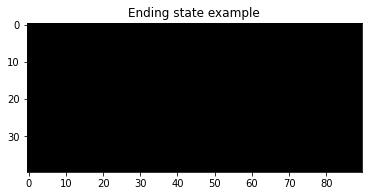

In [29]:
# Example screens
# Unprocessed screen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title("Pole cart image")
plt.show()

# Processed screen
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

# Starting State 
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

# Non starting state 
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

# Ending State 
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

In [1]:
# Utility fuctions

def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()